In [2]:
import bempp.api
import numpy as np
import scipy
import math
import time
import scipy.linalg 
import scipy.linalg.interpolative as sli
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from bempp.api.assembly.blocked_operator import BlockedOperator
from numpy.linalg import slogdet
bempp.api.set_default_device(0, 0)

Sphere-Sphere case 

In [3]:
h = .2   # size of the mesh (element)
center1 = (1.5, 0, 0) # center of one sphere
center2 = (-1.5, 0, 0) # center of the other sphere

sphere1 = bempp.api.shapes.sphere(h=h, origin=center1)
sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)

In [4]:
rwg1_ss = bempp.api.function_space(sphere1, "RWG", 0)
rwg2_ss = bempp.api.function_space(sphere2, "RWG", 0)

snc1_ss = bempp.api.function_space(sphere1, "SNC", 0)
snc2_ss = bempp.api.function_space(sphere2, "SNC", 0)

In [16]:
from bempp.api.utils import Octree
box = sphere1.bounding_box
vertices = np.empty((3,rwg1_ss.global_dof_count),np.float64)
for index in range(rwg1_ss.global_dof_count):
    elem,local_id = rwg1_ss.global2local[index][0]
    edge_id = sphere1.element_edges[local_id,elem]
    vertices[:,index] = .5*(sphere1.vertices[:,sphere1.edges[0,edge_id]] + sphere1.vertices[:,sphere1.edges[0,edge_id]])
tree = Octree(box[:,0],box[:,1], 2,vertices)
sorted_indices = tree.sorted_indices

In [7]:
N = 10
lbound = .05
ubound = 4

# We use an exponentially adapted trapezoid rule.
quad_points = np.linspace(np.exp(-ubound), np.exp(-lbound), N)
results = np.empty(N, dtype='float64')
matrices = []

for index, point in enumerate(quad_points):


    wavenumber = -1j * np.log(point)

    op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg1_ss, snc1_ss, wavenumber)
    op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg2_ss, snc2_ss, wavenumber)
    op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg2_ss, snc2_ss, wavenumber)
    op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg1_ss, snc1_ss, wavenumber)

    mat11 = np.real(op11.weak_form().A)
    mat12 = np.real(op12.weak_form().A)
    mat21 = np.real(op21.weak_form().A)
    mat22 = np.real(op22.weak_form().A)
    ident_mat = np.identity(mat11.shape[0])
    
    sorted_mat11 = mat11[:, sorted_indices][sorted_indices, :]
    sorted_mat12 = mat12[:, sorted_indices][sorted_indices, :]
    sorted_mat22 = mat22[:, sorted_indices][sorted_indices, :]
    sorted_mat21 = mat21[:, sorted_indices][sorted_indices, :]

    A = ident_mat - np.linalg.inv(sorted_mat11)@sorted_mat12@np.linalg.inv(sorted_mat22)@sorted_mat21

    sign, logdet = slogdet(A)
    results[index] = logdet
    matrices.append(A)

In [8]:
n = matrices[0].shape[0]
print(n)

1269


In [9]:
nboxes = 27
size = n//nboxes

In [10]:
def get_box(nx, ny, A, nboxes, n):
    """Return the content of a given box"""
    size = n // nboxes
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return A[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [11]:
def get_con_box(i,A,nboxes,n):
    """Return Ai"""
    BB = A[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(A[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [14]:
def plot_box_ranks(A, nboxes, n, tol=1E-12):
    """Plot rank of the boxes."""
    from scipy.linalg import svdvals
    ranks = np.zeros((nboxes,nboxes),dtype='int32')
    for i in range(nboxes):
        for j in range(nboxes):
            m = get_box(i, j, A, nboxes, n)
            s = svdvals(m)
            ranks[i,j] = np.sum(s>tol)
    plt.imshow(ranks, cmap='Blues')
    clb = plt.colorbar()
    clb.ax.set_title('Rank')

<Figure size 432x288 with 0 Axes>

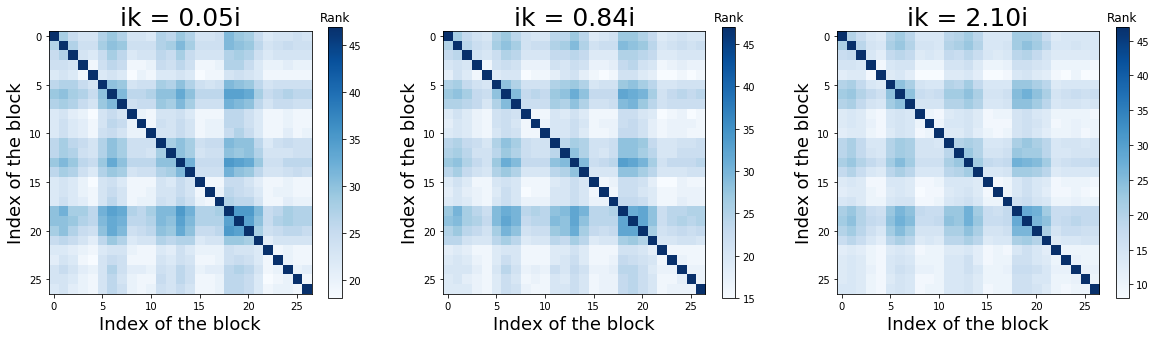

In [26]:
fig = plt.figure()
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plot_box_ranks(matrices[9],nboxes,n)
plt.xlabel('Index of the block', fontsize = 18)
plt.ylabel('Index of the block', fontsize = 18)
plt.title('ik = %.2fi' % (-1 * np.log(quad_points[9])),fontsize = 25)

plt.subplot(1,3,2)
plot_box_ranks(matrices[4],nboxes,n)
plt.xlabel('Index of the block', fontsize = 18)
plt.ylabel('Index of the block', fontsize = 18)
plt.title('ik = %.2fi' % (-1 * np.log(quad_points[4])), fontsize = 25)

plt.subplot(1,3,3)
plot_box_ranks(matrices[1],nboxes,n)
plt.xlabel('Index of the block', fontsize = 18)
plt.ylabel('Index of the block', fontsize = 18)
plt.title('ik = %.2fi' % (-1 * np.log(quad_points[1])), fontsize = 25)
plt.savefig('sorted_rank h=0.2,Z=1.0.pdf')
plt.show()

In [17]:
def L(i,k,A,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,A,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,A,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [18]:
def index_set(k,A,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,A,nboxes,n)[1][0:k])
    return l

In [19]:
def SSS(k,A,nboxes,n):
    ll = index_set(k,A,nboxes,n)
    mat = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ =  get_box(i,j,A,nboxes,n)[ll[i],:]
                mat[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat

In [20]:
def R(i,k,A,nboxes,n):
    RR = np.transpose(L(i,k,A,nboxes,n)[0])
    return RR

In [21]:
def new_S(k,A,nboxes,n):
    mat_ = SSS(k,A,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,A,nboxes,n) @ np.linalg.inv(get_box(i,i,A,nboxes,n)) @ L(i,k,A,nboxes,n)[0])
    return mat_

In [22]:
def logdet_method2(k,A,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,A,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,A,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R(i,k,A,nboxes,n)@np.linalg.inv(get_box(i,i,A,nboxes,n)) @L(i,k,A,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

In [23]:
wn_logdet = np.empty((N,size))
for i in range(N):
    for j in range(1,size+1):
        wn_logdet[i,j-1] = logdet_method2(j,matrices[i],nboxes,n)

In [24]:
wn_err = np.empty((N,size))
for i in range(N):
    for j in range(size):
        wn_err[i,j] = abs((results[i] - wn_logdet[i,j])/results[i])

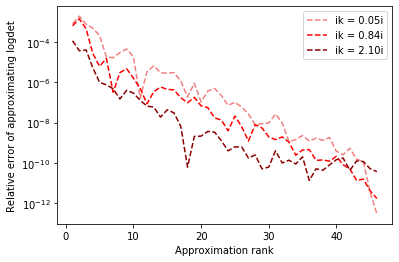

In [27]:
rk = np.linspace(1,size-1,size-1)

vocabulary = [1 , 2 , 3 ]
my_colors = {1:'darkred',2:'red',3:'lightcoral'}
plt.semilogy(rk , wn_err[9,0:size-1], color = my_colors.get(vocabulary[2]), linestyle='--')

plt.semilogy(rk , wn_err[4,0:size-1], color = my_colors.get(vocabulary[1]), linestyle='--')
plt.semilogy(rk , wn_err[1,0:size-1], color = my_colors.get(vocabulary[0]), linestyle='--')

plt.legend(['ik = 0.05i','ik = 0.84i','ik = 2.10i'])
plt.xlabel('Approximation rank')
plt.ylabel('Relative error of approximating logdet')
plt.savefig('sorted_h=0.2,Z=1.0.pdf')